# Import

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import spacy
import preprocessor as tp
import joblib
import gensim

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models.word2vec import Word2Vec

from SBM.TextProcessor import *

c:\users\romain.capocasa\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
train_data = pd.read_csv(os.path.join("data", "train_data.csv"))
test_data = pd.read_csv(os.path.join("data", "test_data.csv"))

In [3]:
nb_no_bullying = len(train_data[train_data['oh_label'] == 0.0])
nb_bullying = len(train_data[train_data['oh_label'] == 1.0])

In [27]:
train_data[train_data['oh_label'] == 1]['Text'].to_list()

["@The_Loki_Jotunn @melisssugh I need a meme of that...that's my day in a nutshell.",
 "@DianH4 @rogue_allah The reason why Mohammed's thugs went to war was to get what they could steal.",
 "Its not the only thing she's done a lot of I'm guessing  #mkr",
 'Apparently you are not following the many misogynists I RT @Ben_Humes Why is everything for girls or related to girls on Twitter? #NotSexist',
 '@comattwow @ChubsSays ...there is no beef here.',
 "RT @demiboyharry I'm not sexist but I don't play a videogames with female main characters",
 '@shacks2cents @JustLaurenB Sweden and the EU...',
 'What a riveting little lesson in walking the catwalk. Thanks ladies #MKR',
 '@exJizyacolector @abunaseeha2 Yes, only Islam can generate that level of barbarity, hatred, and inhumanity. https://t.co/frOHLueT12',
 "@Number10gov I'm totally sick of these politically expedient statements after every attack by Islam on humanity.",
 'Can not stand the head on Kat, horrendous person! #mkr',
 '@LifeInKhil

# Class frequency

Text(0.5, 0.98, 'Tweet class repartition')

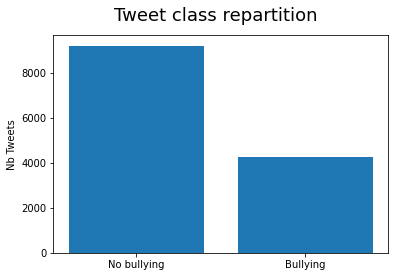

In [4]:
fig, ax = plt.subplots()
ax.bar(["No bullying", "Bullying"], [nb_no_bullying,nb_bullying ])
ax.set_ylabel("Nb Tweets")
fig.suptitle("Tweet class repartition", fontsize=18)

# Get train test

In [7]:
X_train, y_train = train_data['Text'].to_numpy(), train_data['oh_label'].to_numpy()
X_test, y_test = test_data['Text'].to_numpy(), test_data['oh_label'].to_numpy()

# Preprocess text

In [8]:
tp = TextProcessor(remove_punctuation=True, 
                   remove_stop_word=True, 
                   min_word_size=2, 
                   special_token_method=SpecialTokenMethod.PREPROCESS)

In [9]:
X_train_pre = tp.fit_transform(X_train)
X_test_pre = tp.fit_transform(X_test)

# Randomized Search - TFidf
## MultinomialNB

In [13]:
params = {
    'tfidf__use_idf' : (True, False),
    'nb__alpha' : (0.01, 0.1,0.3, 0.5,1.0,1.5,2.0)
}

nb = Pipeline([('tfidf',TfidfVectorizer()), 
                ('nb',MultinomialNB())])

random_search_nb = RandomizedSearchCV(nb, params,scoring='f1', n_iter=10, verbose=3, cv=5, n_jobs=-1)
random_search_nb.fit(X_train_pre, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'nb__alpha': (0.01, 0.1, 0.3, 0.5, 1.0,
                                                      1.5, 2.0),
                                        'tfidf__use_idf': (True, False)},
                   scoring='f1', verbose=3)

### Best model

In [14]:
random_search_nb.best_params_

{'tfidf__use_idf': True, 'nb__alpha': 0.1}

### Evaluate

In [18]:
y_pred_nb = random_search_nb.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78      2300
         1.0       0.51      0.43      0.47      1070

    accuracy                           0.69      3370
   macro avg       0.63      0.62      0.62      3370
weighted avg       0.68      0.69      0.68      3370



In [20]:
print(confusion_matrix(y_test, y_pred_nb))

[[1868  432]
 [ 613  457]]


In [44]:
joblib.dump(random_search_nb, os.path.join('saved_models','tfidf_nb.pkl'))

['saved_models\\tfidf_nb.pkl']

## Random Forest

In [22]:
params = {
    'rfc__n_estimators' : (50,100,150,200),
    'rfc__criterion' : ("gini", "entropy"),
    'rfc__min_samples_split' : (2,3,4),
    'rfc__min_samples_leaf' : (1,3,5),
    'rfc__max_features' : ('auto', 'sqrt', 'log2')
}

rfc = Pipeline([('tfidf',TfidfVectorizer()), 
                ('rfc',RandomForestClassifier())])

random_search_rfc = RandomizedSearchCV(rfc, params,scoring='f1', n_iter=50, verbose=3, cv=5, n_jobs=-1)
random_search_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rfc__criterion': ('gini', 'entropy'),
                                        'rfc__max_features': ('auto', 'sqrt',
                                                              'log2'),
                                        'rfc__min_samples_leaf': (1, 3, 5),
                                        'rfc__min_samples_split': (2, 3, 4),
                                        'rfc__n_estimators': (50, 100, 150,
                                                              200)},
                   scoring='f1', verbose=3)

In [23]:
random_search_rfc.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 4,
 'rfc__min_samples_leaf': 1,
 'rfc__max_features': 'auto',
 'rfc__criterion': 'gini'}

In [24]:
y_pred_rfc = random_search_rfc.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89      2300
         1.0       0.88      0.56      0.69      1070

    accuracy                           0.84      3370
   macro avg       0.85      0.76      0.79      3370
weighted avg       0.84      0.84      0.83      3370



In [26]:
print(confusion_matrix(y_test, y_pred_rfc))

[[2219   81]
 [ 469  601]]


In [43]:
joblib.dump(random_search_rfc, os.path.join('saved_models','tfidf_rfc.pkl'))

['saved_models\\tfidf_rfc.pkl']

## SVM

In [27]:
params = {
    'tfidf__use_idf' : (True, False),
    'svc__penalty' : ('l1', 'l2'),
    'svc__C' : (0.5, 1.0, 2.0),
    'svc__dual':(True,False)
}

svc = Pipeline([('tfidf',TfidfVectorizer()), 
                ('svc',LinearSVC())])

random_search_svc = RandomizedSearchCV(svc, params,scoring='f1', n_iter=50, verbose=3, cv=5, n_jobs=-1)
random_search_svc.fit(X_train, y_train)

c:\users\romain.capocasa\documents\mse\wem\sbm\wem_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\users\romain.capocasa\documents\mse\wem\sbm\wem_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.74286738 0.72849943 0.72748191 0.72020652
 0.74286738 0.72849943        nan        nan 0.74781842 0.74144834
 0.74353519 0.74031546 0.74781842 0.74144834        nan        nan
 0.74306808 0.74471403 0.74401855 0.74287402 0.74331204 0.74471403]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('svc', LinearSVC())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'svc__C': (0.5, 1.0, 2.0),
                                        'svc__dual': (True, False),
                                        'svc__penalty': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)},
                   scoring='f1', verbose=3)

In [28]:
random_search_svc.best_params_

{'tfidf__use_idf': True,
 'svc__penalty': 'l2',
 'svc__dual': True,
 'svc__C': 1.0}

In [39]:
y_pred_svc = random_search_svc.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      2300
         1.0       0.80      0.71      0.75      1070

    accuracy                           0.85      3370
   macro avg       0.84      0.81      0.82      3370
weighted avg       0.85      0.85      0.85      3370



In [41]:
print(confusion_matrix(y_test, y_pred_svc))

[[2111  189]
 [ 310  760]]


In [42]:
joblib.dump(random_search_rfc, os.path.join('saved_models','tfidf_svc.pkl'))

['saved_models\\tfidf_svc.pkl']

# Word2Vec

In [8]:
X_train_token = [i.split() for i in X_train_pre]
X_test_token = [i.split() for i in X_test_pre]

## Create model

In [12]:
w2v_dim = 200

model_w2v = Word2Vec(X_train_token, vector_size=w2v_dim)

In [38]:
model_w2v.save(os.path.join("saved_models","word2vec.model"))

In [13]:
model_w2v.wv.most_similar(positive="racist")

[('feminism', 0.9996818900108337),
 ('white', 0.9996761083602905),
 ('video', 0.9996713399887085),
 ('write', 0.9996585845947266),
 ('article', 0.9996237754821777),
 ('mention', 0.9995882511138916),
 ('understand', 0.9995764493942261),
 ('single', 0.9995691776275635),
 ('see', 0.9995645880699158),
 ('ask', 0.9995644092559814)]

In [17]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

## Create train and test matrix

In [18]:
len_train = len(X_train_token)

wordvec_arrays_train = np.zeros((len_train, w2v_dim)) 
for i in range(len_train):
    wordvec_arrays_train[i,:] = word_vector(X_train_token[i], w2v_dim)
    
wordvec_arrays_train.shape

(13478, 200)

In [20]:
len_test = len(X_test_token)

wordvec_arrays_test = np.zeros((len_test, w2v_dim)) 
for i in range(len_test):
    wordvec_arrays_test[i,:] = word_vector(X_test_token[i], w2v_dim)
    
wordvec_arrays_test.shape

(3370, 200)

## RandomizedSearchCV - Random Forest

In [24]:
params = {
    'n_estimators' : (50,100,150,200),
    'criterion' : ("gini", "entropy"),
    'min_samples_split' : (2,3,4),
    'min_samples_leaf' : (1,3,5),
    'max_features' : ('auto', 'sqrt', 'log2')
}

rfc = RandomForestClassifier()

random_search_rfc = RandomizedSearchCV(rfc, params,scoring='f1', n_iter=30, verbose=3, cv=5, n_jobs=-1)
random_search_rfc.fit(wordvec_arrays_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_features': ('auto', 'sqrt',
                                                         'log2'),
                                        'min_samples_leaf': (1, 3, 5),
                                        'min_samples_split': (2, 3, 4),
                                        'n_estimators': (50, 100, 150, 200)},
                   scoring='f1', verbose=3)

In [25]:
random_search_rfc.best_params_

{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'criterion': 'gini'}

In [27]:
y_pred_rfc = random_search_rfc.predict(wordvec_arrays_test)

In [28]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85      2300
         1.0       0.76      0.45      0.56      1070

    accuracy                           0.78      3370
   macro avg       0.77      0.69      0.71      3370
weighted avg       0.78      0.78      0.76      3370



In [29]:
print(confusion_matrix(y_test, y_pred_rfc))

[[2151  149]
 [ 593  477]]


In [39]:
joblib.dump(random_search_rfc, os.path.join('saved_models','w2v_rfc.pkl'))

['saved_models\\w2v_rfc.pkl']

## RandomizedSearchCV - SVM

In [31]:
params = {
    'penalty' : ('l1', 'l2'),
    'C' : (0.5, 1.0, 2.0),
    'dual':(True,False)
}

svc = LinearSVC()

random_search_svc = RandomizedSearchCV(svc, params,scoring='f1', n_iter=50, verbose=3, cv=5, n_jobs=-1)
random_search_svc.fit(wordvec_arrays_train, y_train)

c:\users\romain.capocasa\documents\mse\wem\sbm\wem_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\users\romain.capocasa\documents\mse\wem\sbm\wem_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.36211645 0.44397151 0.3618267         nan 0.42667167
 0.48839392 0.42612482        nan 0.47660041 0.51821091 0.47643758]
  warnings.warn(
c:\users\romain.capocasa\documents\mse\wem\sbm\wem_env\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RandomizedSearchCV(cv=5, estimator=LinearSVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': (0.5, 1.0, 2.0),
                                        'dual': (True, False),
                                        'penalty': ('l1', 'l2')},
                   scoring='f1', verbose=3)

In [34]:
random_search_svc.best_params_

{'penalty': 'l1', 'dual': False, 'C': 2.0}

In [35]:
y_pred_svc = random_search_svc.predict(wordvec_arrays_test)

In [36]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      2300
         1.0       0.79      0.38      0.51      1070

    accuracy                           0.77      3370
   macro avg       0.78      0.67      0.68      3370
weighted avg       0.78      0.77      0.74      3370



In [37]:
print(confusion_matrix(y_test, y_pred_svc))

[[2192  108]
 [ 662  408]]


In [40]:
joblib.dump(random_search_svc, os.path.join('saved_models','w2v_svc.pkl'))

['saved_models\\w2v_svc.pkl']